# ASSIGNMENT 2A

## Sandeep Sethumadhavan
## 30980283


# 1. Data preparation and exploration 

## 1.1 Creating Spark Session


A SparkConf Object is created with the appname "Assignment 2A" using as many local cores as possible and with an appropriate maxPartitionBytes configuration change.

Using this SparkConf Object, a Spark Session is created.

In [1]:
#Import libraries needed from pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession 
from pyspark import SparkContext
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, when, count, col, split, explode

# Create Spark Configuration Object
master = "local[*]"
app_name = "Assignment 2A"

#changing max partition byte configuration while creating the object
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.files.maxPartitionBytes", 10000000) 


# Create SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

## 1.2 Loading the data 

Loading the data into spark dataframes from the CSV files for both process and memory activities using the schema in the metadata and then cacheing the dataframes. 


For process data:

In [2]:
#Load the CSV File for the process activities while using the Schema from the metadata.
df_process = spark.read.format('csv')\
            .option('header',True).option("inferSchema", "true").option('escape','"')\
            .load('linux_process_*.csv')

#cacheing the dataframe for process
df_process1 = df_process.cache()

For memory data:

In [3]:
#Load the CSV File for the memory activities while using the Schema from the metadata.
df_memory = spark.read.format('csv')\
            .option('header',True).option("inferSchema", "true").option('escape','"')\
            .load('linux_memory_*.csv')

#cacheing the dataframe for memory
df_memory1 = df_memory.cache()

Taking a look at the number of partitions for each dataframe.

In [4]:
print(f"Number of partitions for process data: {df_process1.rdd.getNumPartitions()}")
print(f"Number of partitions for memory data: {df_memory1.rdd.getNumPartitions()}")

Number of partitions for process data: 13
Number of partitions for memory data: 13


Now we look at the row count and the number of columns in each dataframe:
    

In [5]:
%%time
# for process activity data
print((df_process1.count(), len(df_process1.columns)))

(1927968, 17)
CPU times: user 2.99 ms, sys: 5.35 ms, total: 8.34 ms
Wall time: 16.8 s


In [6]:
%%time
# for memory activity data
print((df_memory1.count(), len(df_memory1.columns)))

(2000000, 13)
CPU times: user 4.86 ms, sys: 868 µs, total: 5.73 ms
Wall time: 12.8 s


The schema of both the dataframes are examined to ensure that they are as specified in the metadata.

First for process data:

In [7]:
df_process1.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



The schema of the process activity data follows the specifications. Hence, no changes need to be made.

Next for memory activity data:

In [8]:
df_memory1.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



We can see that the variables MINFLT, MAJFLT, VSTEXT, RSIZE, VGROW and RGROW do not follow the specified schema, hence these columns need to be individually typecasted to the required schema

In [9]:
df_memory1.unpersist()

DataFrame[ts: int, PID: int, MINFLT: string, MAJFLT: string, VSTEXT: string, VSIZE: double, RSIZE: string, VGROW: string, RGROW: string, MEM: double, CMD: string, attack: int, type: string]

In [10]:
df_memory.select('VGROW').distinct().show(20000)

+-------+
|  VGROW|
+-------+
|     -4|
|   4032|
|  58744|
|    296|
|   1572|
|   1512|
|   10.7|
|019.9 3|
|   6240|
|43420 5|
|15692 1|
| 7560 3|
|  052 6|
| 1264 3|
|   2136|
|   1436|
|   -212|
|   7252|
|  44032|
|  191.9|
|   1372|
|    800|
| 7400 1|
| 1032 3|
|   45.4|
| 0152 1|
|  324 6|
|  100 3|
|15356 2|
|  176 1|
|   3368|
|  15052|
|  94336|
|  425.2|
|  33840|
|  83668|
|  337.5|
|   20.5|
|  -10.9|
|  63316|
|  36260|
|  27732|
|  42440|
|   1808|
|   1280|
| 0156 1|
| 0128 1|
|  056 6|
| 1452 2|
|  151.8|
|   16 5|
|  108 3|
| 1156 3|
| 1460 1|
|  10784|
|   74.4|
|   -348|
|    2.6|
|  200.3|
|   2696|
|  112.7|
|   3836|
|  23236|
|  130.3|
|  17260|
|   7056|
|   6900|
|    124|
|   6252|
|  66468|
|  10296|
|   3652|
|   3312|
|   1528|
|   2888|
| 0264 3|
|  056 7|
|  052 4|
|   48 3|
| 0388 3|
|  104 1|
|   5408|
|   -192|
|   6768|
|  170.4|
|  21556|
|   4988|
|   4276|
|  444.5|
|  192.2|
|  352.8|
|  14340|
|  104.8|
|   1500|
|  37152|
| 0644 1|
|21624 7|


Upon examining the columns which need to be typecasted, certain irregularities can be seen, including presence of white space between the numbers and the usage of K and M for 1000 and 1,000,000 respectively. I will now use regualr expressions to try and clean these data.

In [11]:
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

Creating a user defined function to remove white spaces.

In [12]:
spaceDeleteUDF = udf(lambda s: s.replace(" ", ""), StringType()) # user defined function to remove white spaces.

Applying the above function on all the columns that don't follow schema

In [13]:
df_memory=df_memory.withColumn("VGROW", spaceDeleteUDF("VGROW"))
df_memory=df_memory.withColumn("RGROW", spaceDeleteUDF("RGROW"))
df_memory=df_memory.withColumn("RSIZE", spaceDeleteUDF("RSIZE"))
df_memory=df_memory.withColumn("VSTEXT", spaceDeleteUDF("VSTEXT"))
df_memory=df_memory.withColumn("MAJFLT", spaceDeleteUDF("MAJFLT"))
df_memory=df_memory.withColumn("MINFLT", spaceDeleteUDF("MINFLT"))

Creating a user defined function to change K to 000.

In [14]:
changekUDF = udf(lambda s: s.replace("K", "000"), StringType()) # user defined function to change K to 000.

Applying the above function on all the columns that don't follow schema

In [15]:
df_memory=df_memory.withColumn("VGROW", changekUDF("VGROW"))
df_memory=df_memory.withColumn("RGROW", changekUDF("RGROW"))
df_memory=df_memory.withColumn("RSIZE", changekUDF("RSIZE"))
df_memory=df_memory.withColumn("VSTEXT", changekUDF("VSTEXT"))
df_memory=df_memory.withColumn("MAJFLT", changekUDF("MAJFLT"))
df_memory=df_memory.withColumn("MINFLT", changekUDF("MINFLT"))

Creating a user defined function to change M to 000000.

In [16]:
changeMUDF = udf(lambda s: s.replace("M", "000000"), StringType()) # user defined function to change M to 000000.

Applying the above function on all the columns that don't follow schema

In [17]:
df_memory=df_memory.withColumn("VGROW", changeMUDF("VGROW"))
df_memory=df_memory.withColumn("RGROW", changeMUDF("RGROW"))
df_memory=df_memory.withColumn("RSIZE", changeMUDF("RSIZE"))
df_memory=df_memory.withColumn("VSTEXT", changeMUDF("VSTEXT"))
df_memory=df_memory.withColumn("MAJFLT", changeMUDF("MAJFLT"))
df_memory=df_memory.withColumn("MINFLT", changeMUDF("MINFLT"))

Creating a user defined function to change G to 000000000.

In [18]:
changeGUDF = udf(lambda s: s.replace("G", "000000000"), StringType()) # user defined function to change G to 000000000.

Applying the above function on all the columns that don't follow schema

In [19]:
df_memory=df_memory.withColumn("VGROW", changeGUDF("VGROW"))
df_memory=df_memory.withColumn("RGROW", changeGUDF("RGROW"))
df_memory=df_memory.withColumn("RSIZE", changeGUDF("RSIZE"))
df_memory=df_memory.withColumn("VSTEXT", changeGUDF("VSTEXT"))
df_memory=df_memory.withColumn("MAJFLT", changeGUDF("MAJFLT"))
df_memory=df_memory.withColumn("MINFLT", changeGUDF("MINFLT"))

In [20]:
df_memory.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



Cleaning data is completed and now the data is typecasted to follow the schema

In [21]:
# Typecasting the required data to follow schema
df_memory = df_memory.withColumn("MINFLT", df_memory["MINFLT"].cast(IntegerType()))
df_memory = df_memory.withColumn("MAJFLT", df_memory["MAJFLT"].cast(IntegerType()))
df_memory = df_memory.withColumn("VSTEXT", df_memory["VSTEXT"].cast(IntegerType()))
df_memory = df_memory.withColumn("RSIZE", df_memory["RSIZE"].cast(DoubleType()))
df_memory = df_memory.withColumn("VGROW", df_memory["VGROW"].cast(DoubleType()))
df_memory = df_memory.withColumn("RGROW", df_memory["RGROW"].cast(DoubleType()))

In [22]:
df_memory1 = df_memory.cache()

The schema of memory is examined again to ensure that it now follows the required schema.

In [23]:
df_memory1.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: integer (nullable = true)
 |-- VSTEXT: integer (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



The schema is followed.

Now, the dataframes are checked for null values and the count for each column is displayed.

In [24]:
#count of null for process activity
df_process1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_process1.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



There are no null values in any of the columns in process. Now taking a look at memory activity.

In [25]:
#count of null for memory activity
df_memory1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_memory1.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



Dropping the rows with null values in memory activity

In [26]:
df_memory=df_memory.na.drop() 

In [27]:
df_memory1=df_memory.cache()

## 1.3 Exploring the data 

Showing the count of attack and non attack activities based on the column "attack" in both the dataframes.

In [28]:
# count of attack and non attack in process
df_process1.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+



In [29]:
# count of attack and non attack in memory
df_memory1.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+



Showing the count of each type of attack based on the column "type" in both the dataframes.

In [30]:
# count of type for process
df_process1.groupBy("type").count().show()

+---------+-------+
|     type|  count|
+---------+-------+
|      xss|  17759|
| password|  51409|
| scanning|  38449|
|     ddos|  71603|
|   normal|1636604|
|     mitm|    112|
|injection|  41311|
|      dos|  70721|
+---------+-------+



In [31]:
# count of type for memory
df_memory1.groupBy("type").count().show()

+---------+-------+
|     type|  count|
+---------+-------+
| password|  26016|
|     ddos|  45689|
|   normal|1794377|
|     mitm|    112|
|injection|  58523|
|      dos|  75283|
+---------+-------+



Here is a look at the cross tabulation of type and attack counts

In [32]:
df_memory1.stat.crosstab("attack","type").show()

+-----------+-----+-----+---------+----+-------+--------+
|attack_type| ddos|  dos|injection|mitm| normal|password|
+-----------+-----+-----+---------+----+-------+--------+
|          1|45689|75283|    58523| 112|      0|   26016|
|          0|    0|    0|        0|   0|1794377|       0|
+-----------+-----+-----+---------+----+-------+--------+



In [33]:
df_process1.stat.crosstab("attack","type").show()

+-----------+-----+-----+---------+----+-------+--------+--------+-----+
|attack_type| ddos|  dos|injection|mitm| normal|password|scanning|  xss|
+-----------+-----+-----+---------+----+-------+--------+--------+-----+
|          1|71603|70721|    41311| 112|      0|   51409|   38449|17759|
|          0|    0|    0|        0|   0|1636604|       0|       0|    0|
+-----------+-----+-----+---------+----+-------+--------+--------+-----+



We can clearly see a class imbalance in the number of attack and non attack activities in both the dataframes, with the data heavily skewed in favour of non-attacks. The ratio of attack to non attack activities in process is close to 1:7 and is 1:9 in memory. This huge imbalance can affect our model when we train the dataset since the huge majority bias means the minority class might be ignored completely when we do predictions. This is especially harmful when it is the minority class that we are interested in predicting. This issue can be fixed later by utilising undersampling (removing majority class data from training set) or by oversampling(duplicating the minority class data).







Finding basic statistics for the numeric features in both datasets:

In [34]:
#for process activity
#extracting numeric features
process_cols=['ts','PID','TRUN','TSLPI','TSLPU','NICE','PRI','RTPR','CPUNR','EXC','CPU']
#creating dataframe with numeric features
process_numeric = df_process1[process_cols]
#using describe() to get basic statistics
process_numeric.describe().show(5) 

+-------+--------------------+-----------------+-------------------+-----------------+--------------------+-----------------+------------------+-------+------------------+--------------------+-------------------+
|summary|                  ts|              PID|               TRUN|            TSLPI|               TSLPU|             NICE|               PRI|   RTPR|             CPUNR|                 EXC|                CPU|
+-------+--------------------+-----------------+-------------------+-----------------+--------------------+-----------------+------------------+-------+------------------+--------------------+-------------------+
|  count|             1927968|          1927968|            1927968|          1927968|             1927968|          1927968|           1927968|1927968|           1927968|             1927968|            1927968|
|   mean|1.5563198311840394E9|5068.709770597852| 0.0632287465352122|3.508334163222626|3.610018423542299...|4.634469555511295|111.26826741937626|    

In [35]:
#for memory activity
#extracting numeric features
memory_cols=['ts','PID','MINFLT','MAJFLT','VSTEXT','VSIZE','RSIZE','VGROW','RGROW','MEM']
#creating dataframe with numeric features
memory_numeric = df_memory1[memory_cols]
#using describe() to get basic statistics
memory_numeric.describe().show(5) 

+-------+------------------+------------------+----------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+
|summary|                ts|               PID|          MINFLT|           MAJFLT|           VSTEXT|            VSIZE|             RSIZE|            VGROW|             RGROW|                 MEM|
+-------+------------------+------------------+----------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+
|  count|           2000000|           2000000|         2000000|          2000000|          2000000|          2000000|           2000000|          2000000|           2000000|             2000000|
|   mean|1.55624581707609E9|       4999.360446|      983.344344|      1104.864331|    46453.2681675|4496.419966450978| 6122.906264200118|984.4668735599997|483.17466254999994|0.003385164999998...|
| stddev| 984463.368

Now to find top 10 words and count for each non numeric feature (excluding type):

In [36]:
print("Top 10 words and count for non-numeric features in Process (excluding Type):")

# splitting each column value into words based on whitespace, group by words and count occurences 
# ordering by descending order and showing top ten values

#for feature POLI
print("\n POLI:\n")
df_process1.withColumn('words',split(col('POLI'),' '))\
.withColumn('word',explode(col('words')))\
.drop('value','words').groupBy('word').agg(count('word')\
 .alias('count')).orderBy('count',ascending=False).show(10) 


#for feature Status
print("\n Status:\n")
df_process1.withColumn('words',split(col('Status'),' '))\
.withColumn('word',explode(col('words')))\
.drop('value','words').groupBy('word').agg(count('word')\
 .alias('count')).orderBy('count',ascending=False).show(10)


#for feature State
print("\n State:\n")
df_process1.withColumn('words',split(col('State'),' '))\
.withColumn('word',explode(col('words')))\
.drop('value','words').groupBy('word').agg(count('word')\
 .alias('count')).orderBy('count',ascending=False).show(10)


#for feature CMD
print("\n CMD:\n")
df_process1.withColumn('words',split(col('CMD'),' '))\
.withColumn('word',explode(col('words')))\
.drop('value','words').groupBy('word').agg(count('word')\
 .alias('count')).orderBy('count',ascending=False).show(10)


Top 10 words and count for non-numeric features in Process (excluding Type):

 POLI:

+----+-------+
|word|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+


 Status:

+----+-------+
|word|  count|
+----+-------+
|   -|1416322|
|   0| 438984|
|  NE|  48602|
|   N|  23313|
|  NS|    743|
|   C|      3|
|  NC|      1|
+----+-------+


 State:

+----+-------+
|word|  count|
+----+-------+
|   S|1676350|
|   I|  98986|
|   R|  84753|
|   E|  66410|
|   Z|   1118|
|   D|    344|
|   T|      7|
+----+-------+


 CMD:

+--------------+------+
|          word| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



In [37]:
print("Top 10 words and count for non-numeric features in Memory (excluding Type):")

# splitting each column value into words based on whitespace, group by words and count occurences 
# ordering by descending order and showing top ten values
#for feature CMD
print("\n CMD:\n")
df_memory1.withColumn('words',split(col('CMD'),' '))\
.withColumn('word',explode(col('words')))\
.drop('value','words').groupBy('word').agg(count('word')\
 .alias('count')).orderBy('count',ascending=False).show(10)

Top 10 words and count for non-numeric features in Memory (excluding Type):

 CMD:

+----------+------+
|      word| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



To plot the features, I will be using seaborn and matplotlib

In [38]:
# uncomment following line to install seaborn
# !pip install seaborn

In [39]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

Converting the dataframes to pandas for plotting

Plots for process Activity

In [40]:
#converting process activity to pandas
pd_process = df_process1.sample(False,0.2,seed=1234).toPandas()

Text(0.5, 1.0, 'Triangle Correlation Heatmap for Process')

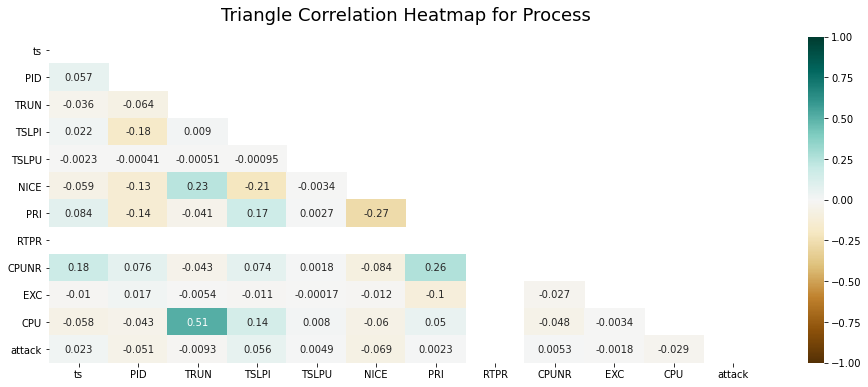

In [41]:
#creating correlation heatmap plot
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(pd_process.corr(), dtype=np.bool))
#creating heatmap based on correlation of the features
heatmap = sns.heatmap(pd_process.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap for Process', fontdict={'fontsize':18}, pad=16)

Using seaborn and the correlation function available in pandas, I have created a triangle correlation heatmap of all the features in the process activity. The colour coding legend as well as the numerical labels helps display the correlation between the different variables. From this we can easily make out how different features are related to each other, with the strongest correlation being seen between CPU and TRUN, while we can notice that RTPR bears no correlation with any of the features. 

Text(0.5, 1.0, 'Features Correlating with attack for Process')

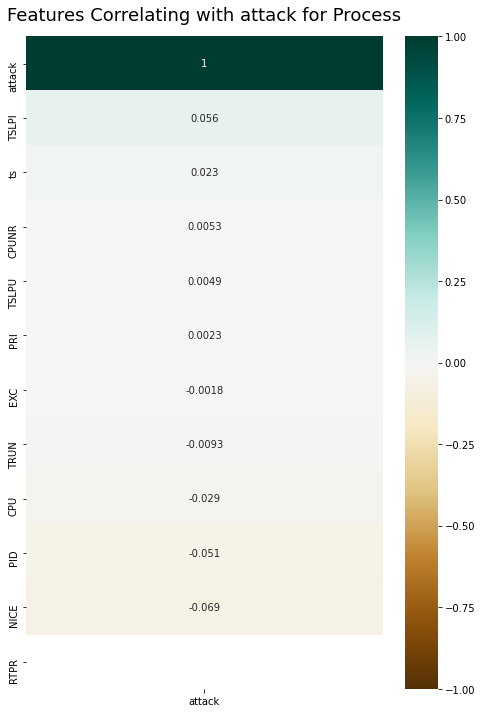

In [42]:
#creating a heatmap plot for features against only attack.
plt.figure(figsize=(8, 12))
#creating heatmap based on correlation of the features with only attack.
heatmap = sns.heatmap(pd_process.corr()[['attack']].sort_values(by='attack', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with attack for Process', fontdict={'fontsize':18}, pad=16)

While the previous plot can be overwhelming and contains too much data to process easily, this plot gives a clearer idea of how the features are correlating with attack. On top of being colour coded and the numerical value being displayed, the plot also orders the features according to the correlation coefficient. The features at the very top are positively correlated and the ones at the bottom are negatively correlated to attack. The ones in the middle show weaker correlation and RTPR which has no colour coding implies it is not correlated to attack.

Now for memory activity the dataframe is converted to pandas and then using seaborn, the features are plotted

In [43]:
#convert memory activity to pandas
pd_memory = df_memory1.sample(False,0.1,seed=1234).toPandas()

Text(0.5, 1.0, 'Triangle Correlation Heatmap for Memory')

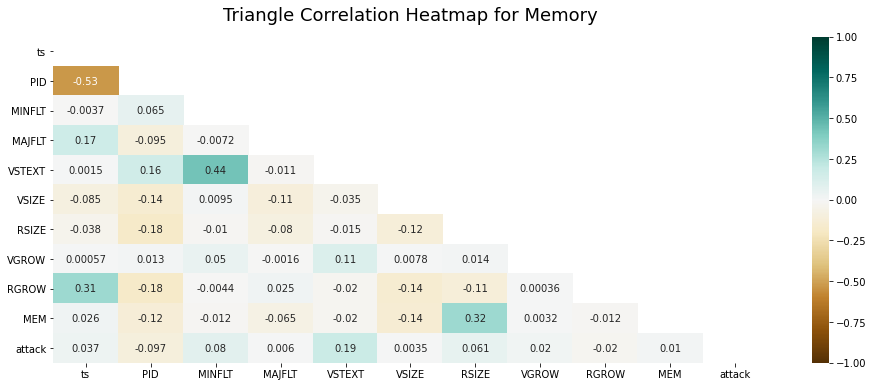

In [44]:
#creating correlation heatmap plot
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(pd_memory.corr(), dtype=np.bool))
#creating heatmap based on correlation of the features
heatmap = sns.heatmap(pd_memory.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap for Memory', fontdict={'fontsize':18}, pad=16)

Using seaborn and the correlation function available in pandas, I have created a triangle correlation heatmap of all the features in the process activity. The colour coding legend as well as the numerical labels helps display the correlation between the different variables. From this we can easily make out how different features are related to each other, with the strongest correlation being seen between PID and ts, while we can notice that MINFLT has weak correlation with all the other variables.

Text(0.5, 1.0, 'Features Correlating with attack for Memory')

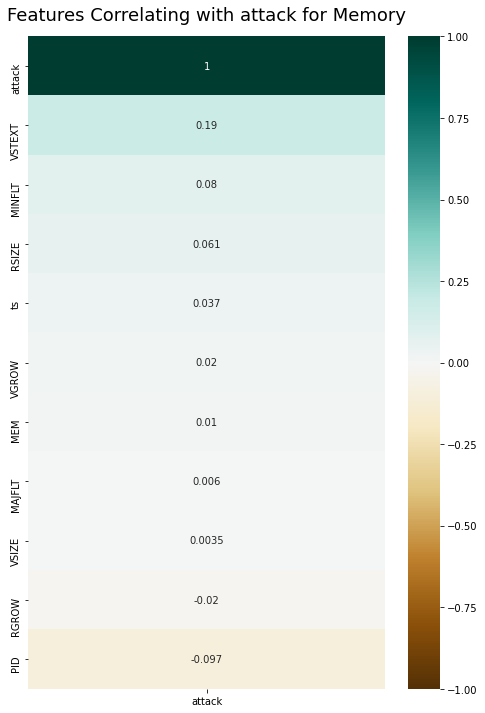

In [45]:
#creating a heatmap plot for features against only attack.
plt.figure(figsize=(8, 12))
#creating heatmap based on correlation of the features with only attack.
heatmap = sns.heatmap(pd_memory.corr()[['attack']].sort_values(by='attack', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with attack for Memory', fontdict={'fontsize':18}, pad=16)

While the previous plot can be overwhelming and contains too much data to process easily, this plot gives a clearer idea of how the features are correlating with attack. On top of being colour coded and the numerical value being displayed, the plot also orders the features according to the correlation coefficient. Compared to the plot for process, we can see more features have a higher correlation coefficient with the target variable.

# 2. Feature extraction and ML training 


## 2.1 Preparing the training data and testing data 


Randomly splitting the data for both process and memory activities with a 80/20 split between training and testing data.

In [46]:
# for process 
train_process, test_process = df_process1.randomSplit([0.8, 0.2], seed = 2020)

#for memory
train_memory, test_memory = df_memory1.randomSplit([0.8, 0.2], seed = 2020)

Now to rebalance the training data with a 1:2 ratio between attack and non attack events while including 20% of attack events from training data.


First to take a look at the number of attack events in the training set of both process and memory.

In [47]:
#count of attack and non attack for process
train_process.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 233309|
|     0|1308387|
+------+-------+



In [48]:
#count of attack and non attack for memory
train_memory.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 164220|
|     0|1435215|
+------+-------+



Now we filter the attack and non attack events from the training data and then use it to resample the training dataset in a 1:2 ratio. First we take 20% of attack events before we undersample the non attack events.

First, doing the above for process:

In [49]:
#doing it for process activity
#non attack events from training
major_process = train_process.filter(col("attack") == 0)
#attack events from training
minor_process1 = train_process.filter(col("attack") == 1)
#taking 20% of attack events from training.
minor_process = minor_process1.sample(False, 1/5,seed=4567)
# undersample the non attack events in a 1:2 ratio
sampled_majority_process = major_process.sample(False, 2*minor_process.count()/major_process.count(),seed=4567)
#combining the attack and non attack events for a resampled training data set
combined_process_2 = sampled_majority_process.unionAll(minor_process)
#displaying the count of attack and non attack events for resampled data.
combined_process_2.groupBy('attack').count().show()

+------+-----+
|attack|count|
+------+-----+
|     1|46858|
|     0|94315|
+------+-----+



We can see that the new split is in a 1:2 ratio. Undersampling for process has been successful. 

Cacheing the resampled data 

In [50]:
rebalanced_training_process= combined_process_2.cache()

Displaying the count of attack and non attack events 

In [51]:
rebalanced_training_process.groupBy('attack').count().show()

+------+-----+
|attack|count|
+------+-----+
|     1|46858|
|     0|94315|
+------+-----+



In [52]:
#count of resampled process data
print("Count of resampled process data: ", rebalanced_training_process.count())

Count of resampled process data:  141173


In [53]:
#doing it for memory activity
#non attack events from training
major_memory = train_memory.filter(col("attack") == 0)
#attack events from training
minor_memory1 = train_memory.filter(col("attack") == 1)
#taking 20% of attack events from training.
minor_memory = minor_memory1.sample(False, 1/5,seed=4567)
# undersample the non attack events in a 1:2 ratio
sampled_majority_memory = major_memory.sample(False, 2*minor_memory.count()/major_memory.count(),seed=4567)
#combining the attack and non attack events for a resampled training data set
combined_memory_2 = sampled_majority_memory.unionAll(minor_memory)
#displaying the count of attack and non attack events for resampled data.
combined_memory_2.groupBy('attack').count().show()

+------+-----+
|attack|count|
+------+-----+
|     1|32733|
|     0|65867|
+------+-----+



We can see that the new split is in a 1:2 ratio. Undersampling for memory has been successful.

Cacheing the resampled data

In [54]:
rebalanced_training_memory= combined_memory_2.cache()

Displaying the count of attack and non attack events 

In [55]:
rebalanced_training_memory.groupBy('attack').count().show()

+------+-----+
|attack|count|
+------+-----+
|     1|32733|
|     0|65867|
+------+-----+



In [56]:
#count of resampled process data
print("Count of resampled memory data: ", rebalanced_training_memory.count())

Count of resampled memory data:  98600


## 2.2 Preparing features, labels and models 

For process data, based on the data exploration conducted earlier, the features TSLPI,ts, CPU, PID and NICE can be selected becuase they had either comparitively high positive correlation coefficients with attack label (TSLPU, ts) or comparitively low negative correlation coefficients with attack label(PID and NICE). The features POLI, Status, State and CMD are the non numeric features that will be selected and they need to undergo string indexing and one hot encoding.

For memory  data, based on the data exploration conducted earlier, the features RSIZE,VSTEXT,ts,VGROW, mem, MAJFLT, RGROW and PID  can be selected becuase they had either comparitively high positive correlation coefficients with attack label (RSIZE,VSTEXT,ts,VGROW, MEM, MAJFLT) or comparitively low negative correlation coefficients with attack label(RGROW and PID).CMD is the only non numeric feature and it needs to be transformed using string indexing and one hot encoding.

The numerical features will need to be scaled since there is a huge variation in the range of the different numerical features and it might lead to the features with bigger values intrinsically affecting the result more due to its larger value. This is not preferred since these features might not be as important. Hence, the numeric features can be normalized using a MinMaxScaler.

In [57]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier


Creating a pipeline model with string indexer, one hot encoding, scaler and estimator for both memory and process activity.


First, completing the model for decision tree estimator using process activity data

In [58]:
#Decision tree for process activity
#Feature Engineering 

#string indexer for non numeric features
process_indexer_dt = StringIndexer(inputCols=['POLI','Status','State','CMD'],outputCols=['POLI_index','Status_index','State_index','CMD_index']).setHandleInvalid("keep")

#one hot encoding the indexed features
process_encoder_dt = OneHotEncoder(inputCols=['POLI_index','Status_index','State_index','CMD_index'],outputCols=['POLI_vec','Status_vec','State_vec','CMD_vec'])

#assembling all the features
process_assembler_dt = VectorAssembler(inputCols=['POLI_vec','Status_vec','State_vec','CMD_vec','TSLPI','ts', 'CPU', 'PID', 'NICE'],outputCol='features')

#scaling the features
process_scaler_dt= MinMaxScaler(inputCol='features', outputCol='scaledFeatures')

#decision tree estimator
process_dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'attack', maxDepth = 3)

#Pipeline API and ML Model
process_pipeline_dt = Pipeline(stages = [process_indexer_dt,process_encoder_dt,process_assembler_dt,process_scaler_dt,process_dt])
process_pipelineModel_dt = process_pipeline_dt.fit(rebalanced_training_process)

Completing the model for gradient boosted tree estimator using process activity data

In [59]:
#Gradient boostedtree for process activity
#Feature Engineering 

#string indexer for non numeric features
process_indexer_gbt = StringIndexer(inputCols=['POLI','Status','State','CMD'],outputCols=['POLI_index','Status_index','State_index','CMD_index']).setHandleInvalid("keep")

#one hot encoding the indexed features
process_encoder_gbt = OneHotEncoder(inputCols=['POLI_index','Status_index','State_index','CMD_index'],outputCols=['POLI_vec','Status_vec','State_vec','CMD_vec'])

#assembling all the features
process_assembler_gbt = VectorAssembler(inputCols=['POLI_vec','Status_vec','State_vec','CMD_vec','TSLPI','ts', 'CPU', 'PID', 'NICE'],outputCol='features')

#scaling the features
process_scaler_gbt= MinMaxScaler(inputCol='features', outputCol='scaledFeatures')

#decision tree estimator
process_gbt = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10)

#Pipeline API and ML Model
process_pipeline_gbt = Pipeline(stages = [process_indexer_gbt,process_encoder_gbt,process_assembler_gbt,process_scaler_gbt,process_gbt])
process_pipelineModel_gbt = process_pipeline_gbt.fit(rebalanced_training_process)

Completing the model for decision tree estimator using memory activity data

In [60]:
#Decision tree for memory activity
#Feature Engineering 

#string indexer for non numeric features
mem_indexer_dt = StringIndexer(inputCols=['CMD'],outputCols=['CMD_index']).setHandleInvalid("keep")

#one hot encoding the indexed features
mem_encoder_dt = OneHotEncoder(inputCols=['CMD_index'],outputCols=['CMD_vec'])

#assembling all the features
mem_assembler_dt = VectorAssembler(inputCols=['CMD_vec','RSIZE','VSTEXT','ts','VGROW', 'MEM', 'MAJFLT', 'RGROW','PID'],outputCol='features')

#scaling the features
mem_scaler_dt= MinMaxScaler(inputCol='features', outputCol='scaledFeatures')

#decision tree estimator
memory_dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)

#Pipeline API and ML Model
mem_pipeline_dt = Pipeline(stages = [mem_indexer_dt,mem_encoder_dt,mem_assembler_dt, mem_scaler_dt, memory_dt])
mem_pipelineModel_dt = mem_pipeline_dt.fit(rebalanced_training_memory)

Completing the model for gradient boosted tree estimator using memory activity data

In [61]:
#Gradient boosted tree for memory activity
#Feature Engineering 

#string indexer for non numeric features
mem_indexer_gbt = StringIndexer(inputCols=['CMD'],outputCols=['CMD_index']).setHandleInvalid("keep")

#one hot encoding the indexed features
mem_encoder_gbt = OneHotEncoder(inputCols=['CMD_index'],outputCols=['CMD_vec'])

#assembling all the features
mem_assembler_gbt = VectorAssembler(inputCols=['CMD_vec','RSIZE','VSTEXT','ts','VGROW', 'MEM', 'MAJFLT', 'RGROW','PID'],outputCol='features')

#scaling the features
mem_scaler_gbt= MinMaxScaler(inputCol='features', outputCol='scaledFeatures')

#decision tree estimator
memory_gbt = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10)

#Pipeline API and ML Model
mem_pipeline_gbt = Pipeline(stages = [mem_indexer_gbt,mem_encoder_gbt,mem_assembler_gbt,mem_scaler_gbt,memory_gbt])
mem_pipelineModel_gbt = mem_pipeline_gbt.fit(rebalanced_training_memory)

## 2.3 Training and evaluating models


Using the pipeline models developed above to make predictions in each of the cases.

Decision tree model for process data


In [62]:
#Decision tree model for process data

# Make predictions
process_predictions_dt = process_pipelineModel_dt.transform(test_process)
process_predictions_dt.show(5)

+----------+-----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+-------------+------+------+----------+------------+-----------+---------+-------------+-------------+-------------+-----------------+--------------------+--------------------+---------------+--------------------+----------+
|        ts|  PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|          CMD|attack|  type|POLI_index|Status_index|State_index|CMD_index|     POLI_vec|   Status_vec|    State_vec|          CMD_vec|            features|      scaledFeatures|  rawPrediction|         probability|prediction|
+----------+-----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+-------------+------+------+----------+------------+-----------+---------+-------------+-------------+-------------+-----------------+--------------------+--------------------+---------------+--------------------+----------+
|1554216895|10329|   0|    0|    0|   0|   0|  0|   0|    0|    NE|  0|    E|0.0|<

Gradient Boosted Tree Model for Process Data

In [63]:
# Gradient Boosted Tree Model for Process Data

# Make predictions
process_predictions_gbt = process_pipelineModel_gbt.transform(test_process)
process_predictions_gbt.show(5)


+----------+-----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+-------------+------+------+----------+------------+-----------+---------+-------------+-------------+-------------+-----------------+--------------------+--------------------+--------------------+--------------------+----------+
|        ts|  PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|          CMD|attack|  type|POLI_index|Status_index|State_index|CMD_index|     POLI_vec|   Status_vec|    State_vec|          CMD_vec|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+----------+-----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+-------------+------+------+----------+------------+-----------+---------+-------------+-------------+-------------+-----------------+--------------------+--------------------+--------------------+--------------------+----------+
|1554216895|10329|   0|    0|    0|   0|   0|  0|   0|    0|    NE|

Decision tree model for memory data

In [64]:
#Decision tree model for memory data

# Make predictions
memory_predictions_dt = mem_pipelineModel_dt.transform(test_memory)
memory_predictions_dt.show(5)


+----------+-----+------+------+------+-----+-----+-----+-----+---+---------+------+------+---------+-----------------+--------------------+--------------------+--------------+--------------------+----------+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|      CMD|attack|  type|CMD_index|          CMD_vec|            features|      scaledFeatures| rawPrediction|         probability|prediction|
+----------+-----+------+------+------+-----+-----+-----+-----+---+---------+------+------+---------+-----------------+--------------------+--------------------+--------------+--------------------+----------+
|1554216895|10007|     0|     0|     0|  0.0|  0.0|  0.0|  0.0|0.0|  <mkdir>|     0|normal|    149.0|(419,[149],[1.0])|(427,[149,421,426...|(427,[149,419,421...|[24827.0,23.0]|[0.99907444668008...|       0.0|
|1554216915|10011|     0|     0|     0|  0.0|  0.0|  0.0|  0.0|0.0|     <cp>|     0|normal|    147.0|(419,[147],[1.0])|(427,[147,421,426...|(427,[147,419,421...|[24

Gradient Boosted Tree Model for Memory Data

In [65]:
# Gradient Boosted Tree Model for Memory Data


# Make predictions
memory_predictions_gbt = mem_pipelineModel_gbt.transform(test_memory)
memory_predictions_gbt.show(5)


+----------+-----+------+------+------+-----+-----+-----+-----+---+---------+------+------+---------+-----------------+--------------------+--------------------+--------------------+--------------------+----------+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|      CMD|attack|  type|CMD_index|          CMD_vec|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+----------+-----+------+------+------+-----+-----+-----+-----+---+---------+------+------+---------+-----------------+--------------------+--------------------+--------------------+--------------------+----------+
|1554216895|10007|     0|     0|     0|  0.0|  0.0|  0.0|  0.0|0.0|  <mkdir>|     0|normal|    149.0|(419,[149],[1.0])|(427,[149,421,426...|(427,[149,419,421...|[1.32590267922034...|[0.93412217565278...|       0.0|
|1554216915|10011|     0|     0|     0|  0.0|  0.0|  0.0|  0.0|0.0|     <cp>|     0|normal|    147.0|(419,[147],[1.0])|(427,[147,421,426...|

For each use case, displaying the count of attack label and prediction:
    
    
First, for decision tree model for process data

In [66]:
process_predictions_dt.groupBy('attack', 'prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|   842|
|     0|       0.0|272844|
|     1|       1.0| 57213|
|     0|       1.0| 55373|
+------+----------+------+



Gradient Boosted Tree Model for process data

In [67]:
process_predictions_gbt.groupBy('attack', 'prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  4537|
|     0|       0.0|304695|
|     1|       1.0| 53518|
|     0|       1.0| 23522|
+------+----------+------+



Decsision Tree Model for memory data

In [68]:
memory_predictions_dt.groupBy('attack', 'prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  1141|
|     0|       0.0|316816|
|     1|       1.0| 40262|
|     0|       1.0| 42346|
+------+----------+------+



Gradient Boosted Tree Model for memory data

In [69]:
memory_predictions_gbt.groupBy('attack', 'prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  1972|
|     0|       0.0|334384|
|     1|       1.0| 39431|
|     0|       1.0| 24778|
+------+----------+------+



Creating a function to calculate the count of true postive, true negative, false positive and false neagtive predictions as well as accuracy, recall, precision and F1 for each model and it also calculates the AUC

In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [71]:
def confusion_matrix(predictions):
    # Calculate True Negative
    TN = predictions.filter('prediction = 0 AND attack = 0').count()
    # Calculate True Positive
    TP = predictions.filter('prediction = 1 AND attack = 1').count()
    # Calculate False Negative
    FN = predictions.filter('prediction = 0 AND attack = 1').count()
    # Calculate False Positive
    FP = predictions.filter('prediction = 1 AND attack = 0').count()
    # Calculate Accuracy
    acc=(TP+TN)/(TN+TP+FN+FP)
    # Calculate Recall
    recall=(TP/TP+FN)
    # Calculate Precision
    precision=TP/(TP+FP)
    # Calculate F1
    f1=2/((1/recall)+(1/precision))
    # Print the values obtained
    print("TP: %d \nTN: %d \nFP: %d \nFN: %d \naccuracy: %f \nrecall: %f \nprecision: %f \nf1: %f \n"%(TP,TN,FP,FN,acc,recall,precision,f1))
    # Use BinaryClassificationEvaluator to evaluate a model
    # Evaluate model Decision Tree
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="attack")
    auc_dt = evaluator.evaluate(predictions)
    print(auc_dt)
    print(evaluator.getMetricName())

Obtaining performance evaluation metrics for decision tree model for process data

In [72]:
confusion_matrix(process_predictions_dt)

TP: 57213 
TN: 272844 
FP: 55373 
FN: 842 
accuracy: 0.854468 
recall: 843.000000 
precision: 0.508172 
f1: 1.015731 

0.9117776059962694
areaUnderROC


Obtaining performance evaluation metrics for gradient boosted tree model for process data

In [73]:
confusion_matrix(process_predictions_gbt)

TP: 53518 
TN: 304695 
FP: 23522 
FN: 4537 
accuracy: 0.927359 
recall: 4538.000000 
precision: 0.694678 
f1: 1.389144 

0.977949391642429
areaUnderROC


Obtaining performance evaluation metrics for decision tree model for memory data

In [74]:
confusion_matrix(memory_predictions_dt)

TP: 40262 
TN: 316816 
FP: 42346 
FN: 1141 
accuracy: 0.891436 
recall: 1142.000000 
precision: 0.487386 
f1: 0.974357 

0.9387542601130059
areaUnderROC


Obtaining performance evaluation metrics for gradient boosted tree model for memory data

In [75]:
confusion_matrix(memory_predictions_gbt)

TP: 39431 
TN: 334384 
FP: 24778 
FN: 1972 
accuracy: 0.933219 
recall: 1973.000000 
precision: 0.614104 
f1: 1.227826 

0.9831310939128746
areaUnderROC


Accuracy is not a good metric to use when the data set is unbalanced as is the case here. Similarly when we look at Precision and Recall, they depend on false positives and false negatives. In this scenario where we are trying to detect when an attack has happened, false positive is less dangerous than a false negative, since it might affect the security, so precision of the model isn't the best metric. But false positives can still be an issue, since it might create a false sense of insecurity, hence recall by itself isn't the best metric. So F1 can prove to be a middle ground, since it balances the effects of false positive and false negatives, but it might not tell much about the model itself.

Which leaves us with AUC, which gives us a definite idea about how good the model might be by summarizing the trade off between false positives and true positives. Here an AUC between 0.9-1.0 can be considered as a really good model.

To get the top 5 most important features, extract it from the pipeline model in the form of sparse vectors in the following manner.

In [76]:
mem_pipelineModel_gbt.stages[-1].featureImportances

SparseVector(427, {0: 0.0026, 1: 0.0013, 2: 0.0166, 3: 0.0, 7: 0.0, 10: 0.0, 12: 0.0, 17: 0.0072, 33: 0.0, 34: 0.0, 36: 0.0001, 38: 0.0, 45: 0.0, 71: 0.0, 81: 0.0, 116: 0.0, 117: 0.0, 121: 0.0, 123: 0.0003, 140: 0.0, 141: 0.0, 142: 0.0001, 151: 0.0, 161: 0.0, 164: 0.0, 171: 0.0, 174: 0.0, 177: 0.0, 181: 0.0, 212: 0.0, 255: 0.0, 286: 0.0, 296: 0.0, 302: 0.0, 310: 0.0, 419: 0.061, 420: 0.0036, 421: 0.8683, 422: 0.0, 423: 0.0003, 424: 0.002, 425: 0.0003, 426: 0.0362})

But this is not readable, hence,a function is created to map the values in the sparse vector to the attribute names.

In [77]:
import pandas as pd

In [78]:
#user defined function to get the top 5 features. 
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

Extracting top 5 features for decision tree - process activity

In [79]:
ExtractFeatureImp(process_pipelineModel_dt.stages[-1].featureImportances, process_predictions_dt, "features").head(5)

,idx,name,score
1,436,ts,1.0
302,297,CMD_vec_kworker/5:0-ip,0.0
301,296,CMD_vec_kworker/3:3,0.0
300,295,CMD_vec_indicator-blue,0.0
299,294,CMD_vec_gsd-a11y-setti,0.0


We can see that the best features for decision tree - process activity are ts and Status. 

None of the other features have a score greater than 0.

Looking at top 5 features for gradient boosted tree - process activity

In [80]:
ExtractFeatureImp(process_pipelineModel_gbt.stages[-1].featureImportances, process_predictions_gbt, "features").head(6)

,idx,name,score
1,436,ts,0.897713
3,438,PID,0.034605
20,15,CMD_vec_atop,0.027241
8,3,Status_vec_-,0.022423
38,33,CMD_vec_tcpdump,0.005004
32,27,CMD_vec_hud-service,0.003086


We can see that the best features for gradient boosted tree - process activity are ts, PID, Status(repeated twice in top 5), NICE and CMD(came in 6th).


Looking at top 5 features for decision tree - memory activity


In [81]:
ExtractFeatureImp(mem_pipelineModel_dt.stages[-1].featureImportances, memory_predictions_dt, "features").head(5)

,idx,name,score
2,421,ts,0.999786
1,420,VSTEXT,0.000214
280,272,CMD_vec_<ubuntu-advan>,0.000000
291,283,CMD_vec_<grub-probe>,0.000000
290,282,CMD_vec_<cat>,0.000000


We can see that the best feature for decision tree - memory activity is ts

None of the other features have a score greater than 0.

Looking at top 5 features for gradient boosted tree - memory activity


In [82]:
ExtractFeatureImp(mem_pipelineModel_gbt.stages[-1].featureImportances, memory_predictions_gbt, "features").head(7)

,idx,name,score
2,421,ts,0.868341
0,419,RSIZE,0.060986
7,426,PID,0.036172
10,2,CMD_vec_vmtoolsd,0.016642
25,17,CMD_vec_tcpdump,0.007173
1,420,VSTEXT,0.003557
8,0,CMD_vec_atop,0.002563


We can see that the best features for gradient boosted tree - memory activity are ts,PID, RSIZE, CMD (3 occurences) and  MEM.

For both process and memory activities, it can be summarized that the gradient boosted model is better since it has higher AUC, accuracy, precision and f1 values. Moreover, the decision tree for both activities show a heavy importance only on ts.

I think ts should be included in the model, since it is the most important feature in every use case, and shows its importance in predicting the model.The timestamp could be important in understanding the attacks on systems, because coordinated attacks and other attacks might show pattern in terms of its regularity and when it occurs. 


Hence, I choose the gradient boosted tree models for both use cases as the preferred model.

Now to visualize ROC curves for Gradient Boosted Tree Model for process and activity.

First import required packages.

In [83]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.types import StructType,StructField

Create a list of thresholds

In [84]:
threshold=np.linspace(0, 1, 10)

Creating a function to get the TPR and FPR values for each threshold

In [85]:
#udf
def rocfunction(predictions):
    #User Defined Function to split the probabilities into two columns
    to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

    #Splitting the probability to 2 parts using the UDF
    df = predictions.withColumn('probability', to_array('probability'))

    #A new df which contains the probabilites in separate columns
    prob_df = df.select(df.probability[0].alias('negative_prob'),df.probability[1].alias('positive_prob'),'attack')
    
    #a list to store values
    roc=[]
    #Here based on the threshold, the prediction column is computed
    for i in threshold:

        #for each threshold , lets calculate the TN,TP,FN,FP from confusion matrix
        thres=i
        test_df=prob_df.withColumn('prediction',F.when(prob_df.positive_prob > thres,1).otherwise(0))
        tp,tn,fp,fn = returnconfusion_matrix(test_df)  
        
        #get tpr and fpr
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        
        #append values to list
        roc.append((tpr,fpr))
        #return list
    return roc


A function to return TN, TP, FN, FP for the ROC function

In [86]:
def returnconfusion_matrix(predictions):
     # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND attack = 0').count()
    TP = predictions.filter('prediction = 1 AND attack = 1').count()
    FN = predictions.filter('prediction = 0 AND attack = 1').count()
    FP = predictions.filter('prediction = 1 AND attack = 0').count()
    return TP,TN,FP,FN

Call the ROC function for process activity and store data to a list

In [87]:
roc_process=rocfunction(process_predictions_gbt)

Call the ROC function for memory activity and store data to a list

In [88]:
roc_memory=rocfunction(memory_predictions_gbt)

Visualizing the ROC plots

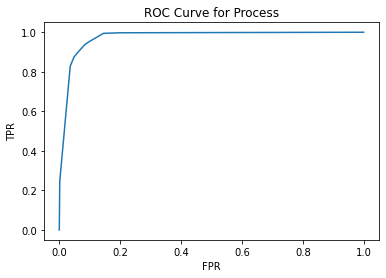

In [89]:
x_val = [x[0] for x in roc_process]
y_val = [x[1] for x in roc_process]

#plotting for Process Activity
plt.plot(y_val,x_val)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve for Process')
plt.show()

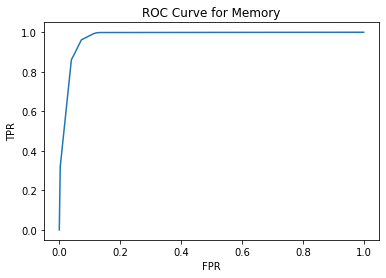

In [90]:
x_val = [x[0] for x in roc_memory]
y_val = [x[1] for x in roc_memory]

# plotting for Memory activity
plt.plot(y_val,x_val)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve for Memory')
plt.show()

Now using the chosen pipeline models for all the attack data

First undersampling is done to get 1:2 ratio of attack to non attack events when taking all attack events from training set. This is done for both process and memory. And then the new resampled data is cached.


Doing the above mentioned for process activity:

In [91]:
# undersample the non attack events in a 1:2 ratio for process
sampled_majority_process12 = major_process.sample(False, 2*minor_process1.count()/major_process.count(),seed=4567)
#combining the attack and non attack events for a resampled training data set
combined_process_1 = sampled_majority_process12.unionAll(minor_process1)
#displaying the count of attack and non attack events for resampled data.
combined_process_1.groupBy('attack').count().show()

+------+------+
|attack| count|
+------+------+
|     1|233309|
|     0|466036|
+------+------+



In [92]:
rebalanced_training_process2= combined_process_1.cache() #cacheing new resampled process data

Doing it again for memory activity

In [93]:
# undersample the non attack events in a 1:2 ratio for memeory
sampled_majority_memory12 = major_memory.sample(False, 2*minor_memory1.count()/major_memory.count(),seed=4567)
#combining the attack and non attack events for a resampled training data set
combined_memory_1 = sampled_majority_memory12.unionAll(minor_memory1)
#displaying the count of attack and non attack events for resampled data.
combined_memory_1.groupBy('attack').count().show()

+------+------+
|attack| count|
+------+------+
|     1|164220|
|     0|328232|
+------+------+



In [94]:
rebalanced_training_memory2= combined_memory_1.cache() #cacheing new sampled memory data

Now the pipeline is constructed again for the process activity for Gradient Boosted Model. Only, this time, we take the best features for the model which has been discovered earlier. 

In [95]:
#Gradient boostedtree for process activity
#Feature Engineering 

#string indexer for non numeric features
process_indexer_gbt2 = StringIndexer(inputCols=['Status','CMD'],outputCols=['Status_index','CMD_index']).setHandleInvalid("keep")

#one hot encoding the indexed features
process_encoder_gbt2 = OneHotEncoder(inputCols=['Status_index','CMD_index'],outputCols=['Status_vec','CMD_vec'])

#assembling all the features
process_assembler_gbt2 = VectorAssembler(inputCols=['Status_vec','CMD_vec','ts', 'PID', 'NICE'],outputCol='features')

#scaling the features
process_scaler_gbt2= MinMaxScaler(inputCol='features', outputCol='scaledFeatures')

#decision tree estimator
process_gbt2 = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10)

#Pipeline API and ML Model
process_pipeline_gbt2 = Pipeline(stages = [process_indexer_gbt2,process_encoder_gbt2,process_assembler_gbt2,process_scaler_gbt2,process_gbt2])
process_pipelineModel_gbt2 = process_pipeline_gbt2.fit(rebalanced_training_process2)

Obtaining predictions using this new model for process data

In [96]:
# Gradient Boosted Tree Model for Process Data

# Make predictions
process_predictions_gbt2 = process_pipelineModel_gbt2.transform(test_process)
process_predictions_gbt2.show(5)

+----------+-----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+-------------+------+------+------------+---------+-------------+-----------------+--------------------+--------------------+--------------------+--------------------+----------+
|        ts|  PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|          CMD|attack|  type|Status_index|CMD_index|   Status_vec|          CMD_vec|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+----------+-----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+-------------+------+------+------------+---------+-------------+-----------------+--------------------+--------------------+--------------------+--------------------+----------+
|1554216895|10329|   0|    0|    0|   0|   0|  0|   0|    0|    NE|  0|    E|0.0|<mkinitramfs>|     0|normal|         2.0|    155.0|(7,[2],[1.0])|(603,[155],[1.0])|(613,[2,162,610,6...|(613,[2,162,610,6...|[1.32603186223

Obtaining the performance metrics for the process activity model.

In [97]:
confusion_matrix(process_predictions_gbt2)

TP: 53048 
TN: 305451 
FP: 22766 
FN: 5007 
accuracy: 0.928100 
recall: 5008.000000 
precision: 0.699712 
f1: 1.399229 

0.9779695626633275
areaUnderROC


When comparing to the values obtained for the previous model, there is a slight improvement for all the performance metrics. Hence we can say that this is the best model for process data

Now the pipeline is constructed again for the memory activity for Gradient Boosted Model. Only, this time, we take the best features for the model which has been discovered earlier. 

In [98]:
#Gradient boosted tree for memory activity
#Feature Engineering 

#string indexer for non numeric features
mem_indexer_gbt2 = StringIndexer(inputCols=['CMD'],outputCols=['CMD_index']).setHandleInvalid("keep")

#one hot encoding the indexed features
mem_encoder_gbt2 = OneHotEncoder(inputCols=['CMD_index'],outputCols=['CMD_vec'])

#assembling all the features
mem_assembler_gbt2 = VectorAssembler(inputCols=['CMD_vec', 'RSIZE', 'ts', 'MEM', 'PID'],outputCol='features')

#scaling the features
mem_scaler_gbt2= MinMaxScaler(inputCol='features', outputCol='scaledFeatures')

#decision tree estimator
memory_gbt2 = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10)

#Pipeline API and ML Model
mem_pipeline_gbt2 = Pipeline(stages = [mem_indexer_gbt2,mem_encoder_gbt2,mem_assembler_gbt2,mem_scaler_gbt2,memory_gbt2])
mem_pipelineModel_gbt2 = mem_pipeline_gbt2.fit(rebalanced_training_memory2)

Obtaining predictions using this new model for memory data

In [99]:
# Gradient Boosted Tree Model for Memory Data


# Make predictions
memory_predictions_gbt2 = mem_pipelineModel_gbt2.transform(test_memory)
memory_predictions_gbt2.show(5)


+----------+-----+------+------+------+-----+-----+-----+-----+---+---------+------+------+---------+-----------------+--------------------+--------------------+--------------------+--------------------+----------+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|      CMD|attack|  type|CMD_index|          CMD_vec|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+----------+-----+------+------+------+-----+-----+-----+-----+---+---------+------+------+---------+-----------------+--------------------+--------------------+--------------------+--------------------+----------+
|1554216895|10007|     0|     0|     0|  0.0|  0.0|  0.0|  0.0|0.0|  <mkdir>|     0|normal|    147.0|(548,[147],[1.0])|(552,[147,549,551...|(552,[147,548,549...|[1.32590267922038...|[0.93412217565278...|       0.0|
|1554216915|10011|     0|     0|     0|  0.0|  0.0|  0.0|  0.0|0.0|     <cp>|     0|normal|    148.0|(548,[148],[1.0])|(552,[148,549,551...|

Obtaining the performance metrics for the process activity model.

In [100]:
confusion_matrix(memory_predictions_gbt2)

TP: 38755 
TN: 335075 
FP: 24087 
FN: 2648 
accuracy: 0.933257 
recall: 2649.000000 
precision: 0.616705 
f1: 1.233124 

0.9839428978493313
areaUnderROC


When comparing to the values obtained for the previous model, there is a slight improvement for all the performance metrics. Hence we can say that this is the best model for memory data

Persisting these models to memory:
    
For process activity

In [105]:
process_pipelineModel_gbt2.save('process_activity_prediction_model_final')

For memory activity

In [106]:
mem_pipelineModel_gbt2.save('memory_activity_prediction_model_final')

# 3. Knowledge sharing 

In [107]:
from pyspark.ml.clustering import KMeans
iris_df = spark.createDataFrame([(4.7, 3.2, 1.3, 0.2), (4.9, 3.1, 1.5, 0.1), (5.4, 3.9, 1.3, 0.4), (5.0, 3.4, 1.6, 0.4), (5.1, 3.8, 1.6, 0.2), (4.9, 2.4, 3.3, 1.0),(6.6, 2.9, 4.6, 1.3), (5.6, 3.0, 4.5, 1.5),(5.7, 2.6, 3.5, 1.0),(5.8, 2.6, 4.0, 1.2),(5.8, 2.8, 5.1, 2.4),(6.2, 2.8, 4.8, 1.8), (6.0, 3.0, 4.8, 1.8),(6.7, 3.1, 5.6, 2.4),(6.7, 3.0, 5.2, 2.3), (6.2, 3.4, 5.4, 2.3)],['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

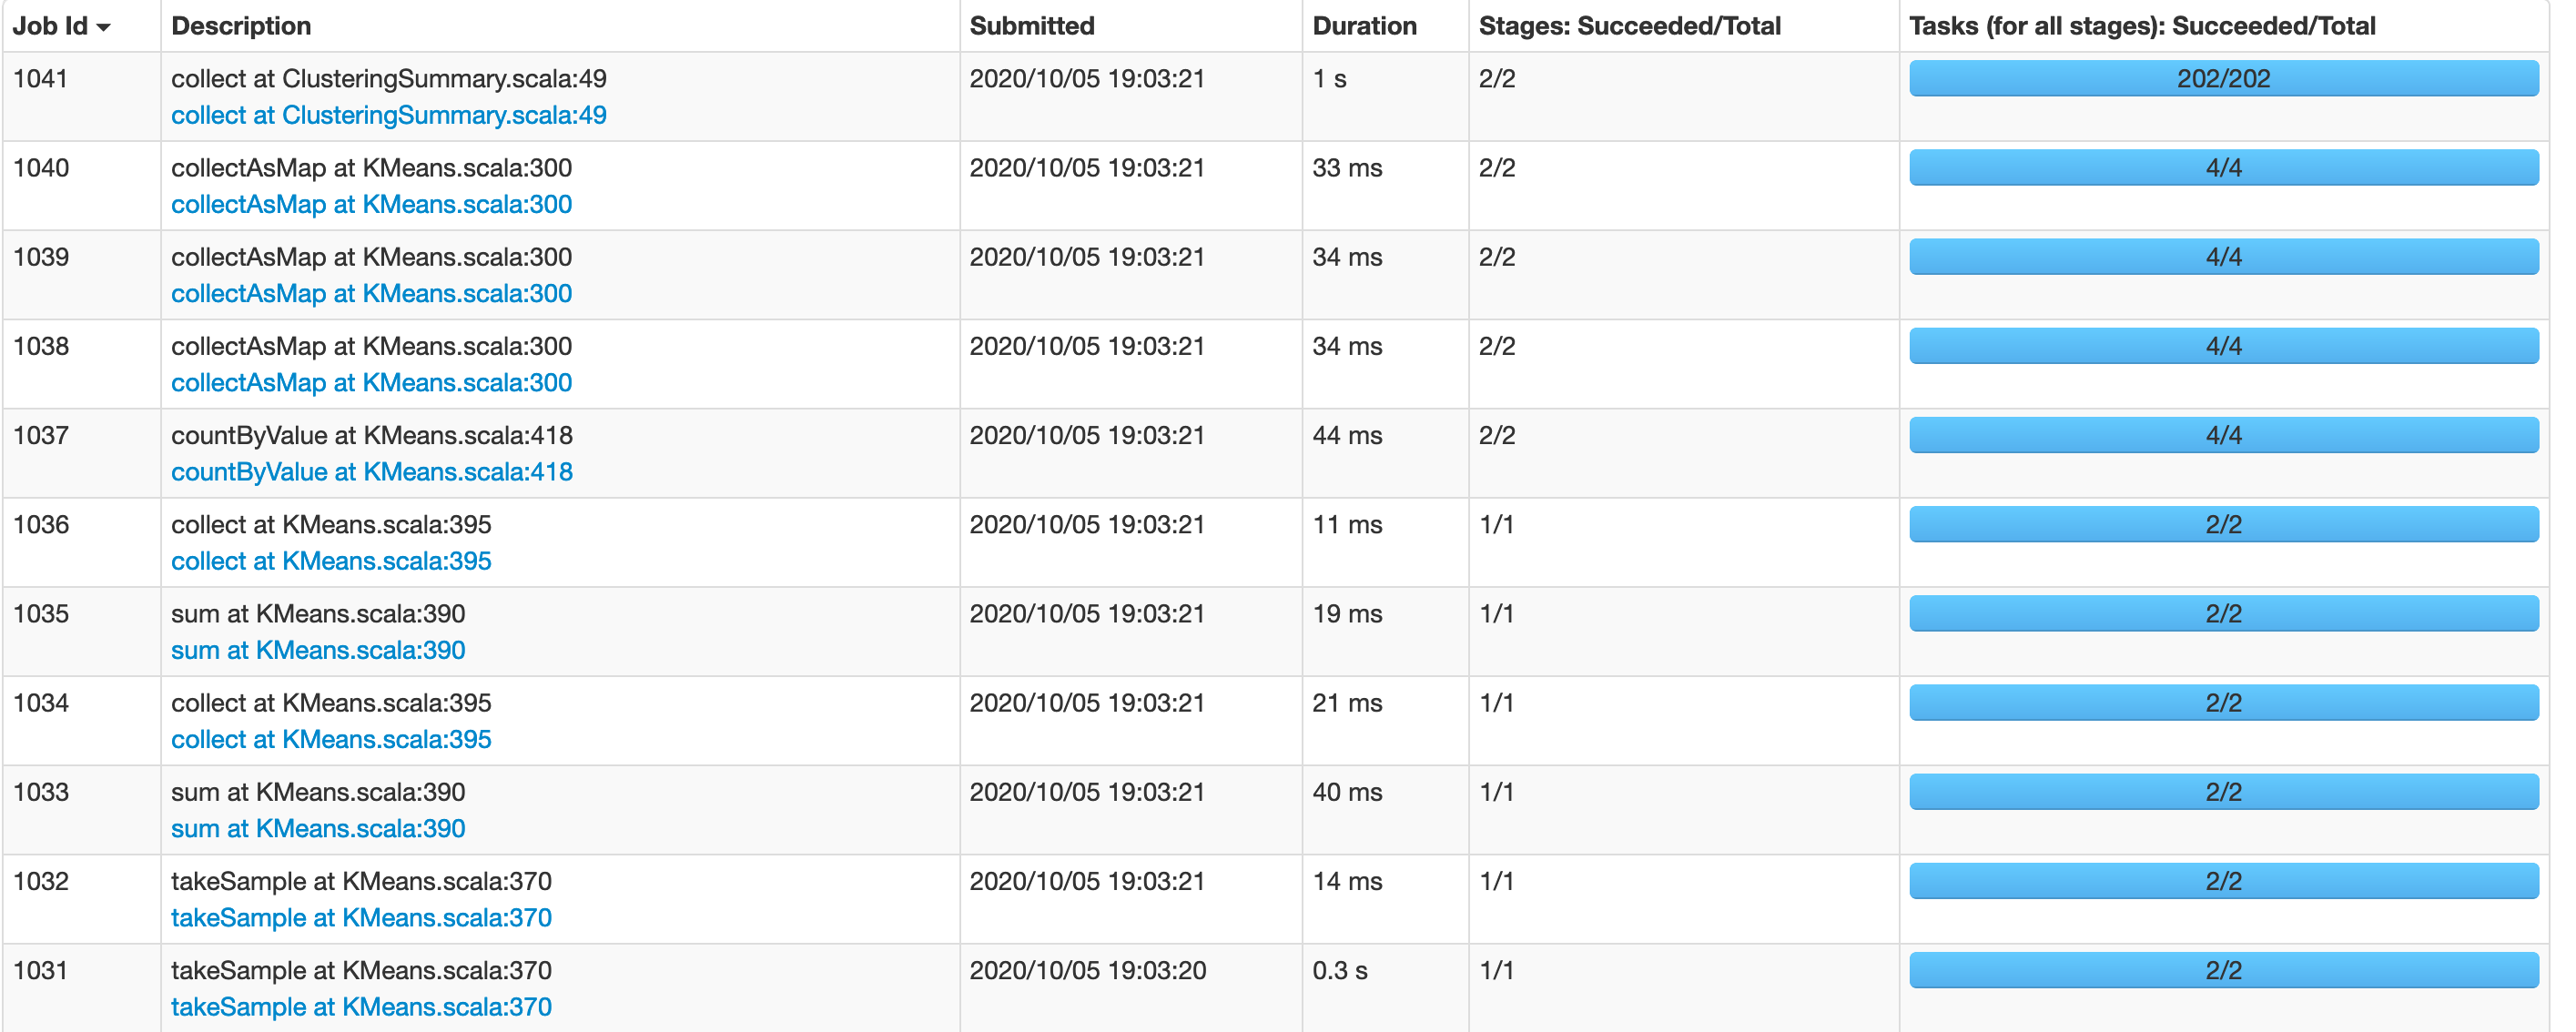

A job is parallel computation which consists of multiple tasks that is created with regards to a Spark action (e.g. save, collect). In the above screenshot we can see 11 jobs which spawns as a result of the code run above. takeSample job returns a fixed-size sampled subset of the RDD which is created above. sum job adds up the element in the RDD. collect job retrieves the data from all the nodes to the dtiven node. countByValue returns the count of each unique value in the RDD as a dictionary while collectasMap returns key value pair in the RDD as a dictionary.

Now these jobs wrt KMeans occurs as follows, after the number of clusters have been specified, takeSample is where the  K data points for the clusters are selected without replacement.sum job is where the sum of squared distance between data points and all clusters are calculated. countbyValue computes the count of all data points which belongs to each clusters. collectasMap assigns each data to the closest cluster and collect at ClusteringSummary returns the centroid for the clusters.


References:


pyspark, W. (2020). Word counter with pyspark. Retrieved 5 October 2020, from https://stackoverflow.com/a/63541577

How to Create a Seaborn Correlation Heatmap in Python?. (2020). Retrieved 5 October 2020, from https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

Lin, T. (2020). Feature Selection Using Feature Importance Score - Creating a PySpark Estimator. Retrieved 5 October 2020, from https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/